# **Swin-UperNet Model Training Notebook (Main)**

## Step 1: Importing Libraries and Mounting Files from Google Drive

In [ ]:
# Install required packages (run this cell only once)
!pip install torch torchvision
!pip install timm==0.9.2
!pip install segmentation-models-pytorch
!pip install torchinfo
!pip install torchmetrics
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

In [2]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
import numpy as np
import timm
from timm import create_model
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import torchvision.transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import torchmetrics
import segmentation_models_pytorch as smp
import albumentations as A
from PIL import Image
from albumentations.pytorch import ToTensorV2
from google.colab import drive
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image

In [3]:
# Mount Google Drive if running on Colab and set BASE_DIR for your processed dataset.
from google.colab import drive
IN_COLAB = "google.colab" in str(get_ipython())
if IN_COLAB:
    print("Running in Google Colab: Mounting Drive...")
    drive.mount('/content/drive')
    # Update the BASE_DIR to point to your folder with processed .npy files
    BASE_DIR = "/content/drive/MyDrive/swinunet-medical-segmentation/dataset/processed_dataset"
else:
    BASE_DIR = "/path/to/local/dataset/processed_dataset"

Running in Google Colab: Mounting Drive...
Mounted at /content/drive


## Step 2: Verify GPU and Environment


In [4]:
print("GPU Available:", torch.cuda.is_available()) # checks if a GPU is accessible.

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Running on device:", device)

GPU Available: True
GPU Name: NVIDIA A100-SXM4-40GB
Running on device: cuda


## Step 3: Define a PyTorch Dataset for Our Preprocessed .npy Files

Now we’ll create a custom Dataset class that reads our images and masks from the .npy files. This allows us to easily use DataLoader for batching and shuffling. (This is a common practice for PyTorch).

In [5]:
class ISICDataset(Dataset):
    def __init__(self, images_path, masks_path, transform=None):
        """
        Args:
            images_path (str): Path to .npy file containing images (N, H, W, C)
            masks_path (str): Path to .npy file containing masks (N, H, W)
            transform (albumentations.Compose): Transformations for data augmentation
        """
        self.images = np.load(images_path)  # shape: (N, H, W, C)
        self.masks  = np.load(masks_path)   # shape: (N, H, W)

        self.transform = transform

    def __len__(self):
        """Return total number of samples"""
        return len(self.images)

    def __getitem__(self, idx):
        """Retrieve image & mask, apply transformations"""
        # Get image & mask
        image = self.images[idx]  # (H, W, C)
        mask  = self.masks[idx]   # (H, W)

        # Apply Albumentations (mask remains 256x256)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"].float()
            mask  = augmented["mask"].long()
        else:
            image = torch.from_numpy(image).permute(2, 0, 1).float()
            mask  = torch.from_numpy(mask).long()

        return image, mask

## Step 4: Define the Data Augmentation Pipeline

Now, we define the Albumentations transforms that will:
1. Apply strong augmentations to the training set (e.g., rotations, brightness shifts, flips).
2. Ensure transformations are applied to both images and masks.

In [19]:
# Train Transform: Apply Augmentations AFTER Resizing
train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.ElasticTransform(p=0.3),  # Reduce Elastic Transform to 0.3 (prevents excessive distortion)
    A.GaussianBlur(p=0.1),  # (too much blur hurts fine segmentation details)
    A.GridDistortion(p=0.3),  # Introduce Grid Distortion (helps CNNs generalize better)
    ToTensorV2()
])

# Validation & Test Transform (No Augmentation)
val_test_transform = A.Compose([
    A.Resize(224, 224),
    ToTensorV2()
])

## Step 5: Create a DataLoader for Training & Validation

Now that we have our ISICDataset class defined, let’s set up the DataLoader. This allows us to:

1. Batch our images and masks (e.g., batches of size 64).
2. Shuffle the data for training.
3. Potentially use multiple workers to speed up data loading.

In [20]:
# Define file paths for training, validation, and test sets
train_images_path = os.path.join(BASE_DIR, "train_images.npy")
train_masks_path  = os.path.join(BASE_DIR, "train_masks.npy")
val_images_path   = os.path.join(BASE_DIR, "val_images.npy")
val_masks_path    = os.path.join(BASE_DIR, "val_masks.npy")
test_images_path  = os.path.join(BASE_DIR, "test_images.npy")
test_masks_path   = os.path.join(BASE_DIR, "test_masks.npy")

# Create dataset instances
train_dataset = ISICDataset(train_images_path, train_masks_path, transform=train_transform)  # Augmented
val_dataset   = ISICDataset(val_images_path, val_masks_path, transform=val_test_transform)  # No augmentation
test_dataset  = ISICDataset(test_images_path, test_masks_path, transform=val_test_transform)  # No augmentation

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=8, pin_memory=True)

# Quick test: Display batch shapes
train_batch = next(iter(train_loader))
images, masks = train_batch
print("Train Images batch shape:", images.shape)  # Expected: [B, 3, H, W]
print("Train Masks batch shape:", masks.shape)    # Expected: [B, H, W]

# Test that test dataset is properly loaded
test_batch = next(iter(test_loader))
test_images, test_masks = test_batch
print("Test Images batch shape:", test_images.shape)
print("Test Masks batch shape:", test_masks.shape)

Train Images batch shape: torch.Size([32, 3, 224, 224])
Train Masks batch shape: torch.Size([32, 224, 224])
Test Images batch shape: torch.Size([32, 3, 224, 224])
Test Masks batch shape: torch.Size([32, 224, 224])


In [21]:
images, masks = next(iter(train_loader))
print("After Normalization:", images.min().item(), images.max().item(), masks.min().item(), masks.max().item())

After Normalization: 0.0 1.0 0 1


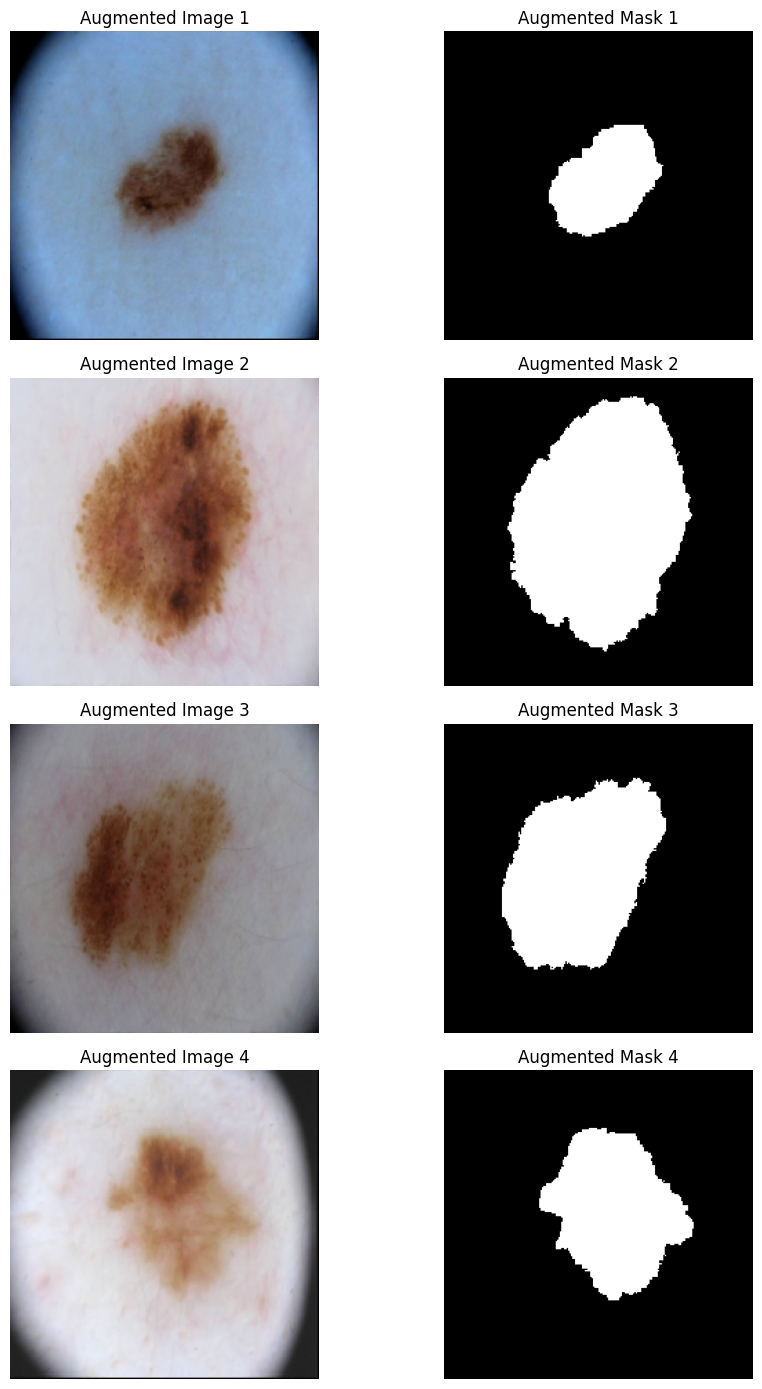

In [22]:
fig, axes = plt.subplots(4, 2, figsize=(10, 14))

for i in range(4):
    img, mask = train_dataset[i+5]  # Load an augmented sample

    img = img.permute(1, 2, 0).numpy()  # Convert image tensor to NumPy
    mask = mask.numpy()  # Convert mask tensor to NumPy

    axes[i, 0].imshow(img)  # Show image
    axes[i, 0].set_title(f"Augmented Image {i+1}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(mask, cmap="gray")  # Show mask
    axes[i, 1].set_title(f"Augmented Mask {i+1}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

## Step 6: Define the Main Swin-UperNet Model

In [23]:
# -------------------------------
# Define Pyramid Pooling Module (with GroupNorm)
# -------------------------------
class PyramidPoolingModule(nn.Module):
    def __init__(self, in_channels, pool_sizes=[1, 2, 3, 6]):
        super().__init__()
        self.pool_layers = nn.ModuleList([
            nn.Sequential(
                nn.AdaptiveAvgPool2d(pool_size),
                nn.Conv2d(in_channels, in_channels // 4, kernel_size=1, bias=False),
                nn.GroupNorm(num_groups=8, num_channels=in_channels // 4),
                nn.ReLU(inplace=True)
            ) for pool_size in pool_sizes
        ])
        total_channels = in_channels + len(pool_sizes) * (in_channels // 4)
        self.conv = nn.Conv2d(total_channels, in_channels, kernel_size=1, bias=False)

    def forward(self, x):
        pooled_features = [x]
        for layer in self.pool_layers:
            pooled = layer(x)
            pooled = F.interpolate(pooled, size=x.shape[2:], mode='bilinear', align_corners=False)
            pooled_features.append(pooled)
        x = torch.cat(pooled_features, dim=1)
        x = self.conv(x)
        return x

# -------------------------------
# Define UPerNet-Style Decoder (With Dropout for UQ)
# -------------------------------
class UPerNetDecoder(nn.Module):
    def __init__(self, encoder_channels, num_classes=1, dropout_rate=0.1):
        """
        Adjusted to dynamically match extracted feature sizes from Swin-Tiny.
        """
        super().__init__()
        self.ppm = PyramidPoolingModule(encoder_channels[-1])  # Use last layer

        self.lateral_conv2 = nn.Conv2d(encoder_channels[2], encoder_channels[-1], kernel_size=1)
        self.conv3 = nn.Sequential(
            nn.Conv2d(encoder_channels[-1], encoder_channels[2], kernel_size=1),
            nn.Dropout2d(p=dropout_rate)
        )

        self.lateral_conv1 = nn.Conv2d(encoder_channels[1], encoder_channels[2], kernel_size=1)
        self.conv2 = nn.Sequential(
            nn.Conv2d(encoder_channels[2], encoder_channels[1], kernel_size=1),
            nn.Dropout2d(p=dropout_rate)
        )

        self.lateral_conv0 = nn.Conv2d(encoder_channels[0], encoder_channels[1], kernel_size=1)
        self.conv1 = nn.Sequential(
            nn.Conv2d(encoder_channels[1], encoder_channels[0], kernel_size=1),
            nn.Dropout2d(p=dropout_rate)
        )

        self.segmentation_head = nn.Conv2d(encoder_channels[0], num_classes, kernel_size=1)

    def forward(self, features):
        f0, f1, f2, f3 = features  # Extracted feature maps from encoder

        x3 = self.ppm(f3)  # Pyramid Pooling on last feature map
        x3_up = F.interpolate(x3, size=f2.shape[2:], mode="bilinear", align_corners=False)
        f2_lat = self.lateral_conv2(f2)
        fuse2 = x3_up + f2_lat
        fuse2 = self.conv3(fuse2)

        fuse2_up = F.interpolate(fuse2, size=f1.shape[2:], mode="bilinear", align_corners=False)
        f1_lat = self.lateral_conv1(f1)
        fuse1 = fuse2_up + f1_lat
        fuse1 = self.conv2(fuse1)

        fuse1_up = F.interpolate(fuse1, size=f0.shape[2:], mode="bilinear", align_corners=False)
        f0_lat = self.lateral_conv0(f0)
        fuse0 = fuse1_up + f0_lat
        fuse0 = self.conv1(fuse0)

        # Ensure final output matches input size (224x224)
        x_out = F.interpolate(fuse0, size=(224, 224), mode="bilinear", align_corners=False)
        output = self.segmentation_head(x_out)
        return output

# -------------------------------
# Define Swin-Tiny UPerNet Model
# -------------------------------
class SwinTinyUPerNet(nn.Module):
    def __init__(self, num_classes=1, dropout_rate=0.1):
        super().__init__()
        self.encoder = timm.create_model(
            "swin_tiny_patch4_window7_224.ms_in22k_ft_in1k",
            pretrained=True,
            features_only=True
        )

        # Extract feature map sizes dynamically
        encoder_channels = self.encoder.feature_info.channels()  # Automatically get correct channels

        # Pass extracted feature sizes to decoder
        self.decoder = UPerNetDecoder(encoder_channels, num_classes, dropout_rate=dropout_rate)

    def forward(self, x, mc_dropout=False):
        features = self.encoder(x)  # Extract feature maps

        # Convert NHWC to NCHW format only if needed
        features = [f.permute(0, 3, 1, 2) if f.dim() == 4 else f for f in features]

        # Decode feature maps back to segmentation mask
        output = self.decoder(features)

        # Ensure output matches input resolution
        output = F.interpolate(output, size=(224, 224), mode="bilinear", align_corners=False)

        if mc_dropout:
            return output, features  # Return feature maps for uncertainty quantification
        return output

# -------------------------------
# Instantiate and Test the Model
# -------------------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SwinTinyUPerNet(num_classes=1).to(device)

    print("Swin-Tiny UPerNet Model Summary:")
    print(summary(model, input_size=(1, 3, 224, 224)))  # Ensure correct input size

    # Test with a dummy input
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    output = model(dummy_input)
    print("Output shape:", output.shape)

Swin-Tiny UPerNet Model Summary:
Layer (type:depth-idx)                             Output Shape              Param #
SwinTinyUPerNet                                    [1, 1, 224, 224]          --
├─FeatureListNet: 1-1                              [1, 56, 56, 96]           --
│    └─PatchEmbed: 2-1                             [1, 56, 56, 96]           --
│    │    └─Conv2d: 3-1                            [1, 96, 56, 56]           4,704
│    │    └─LayerNorm: 3-2                         [1, 56, 56, 96]           192
│    └─SwinTransformerStage: 2-2                   [1, 56, 56, 96]           --
│    │    └─Identity: 3-3                          [1, 56, 56, 96]           --
│    │    └─Sequential: 3-4                        [1, 56, 56, 96]           224,694
│    └─SwinTransformerStage: 2-3                   [1, 28, 28, 192]          --
│    │    └─PatchMerging: 3-5                      [1, 28, 28, 192]          74,496
│    │    └─Sequential: 3-6                        [1, 28, 28, 192]  

## Step 7: Test Swin-UperNet Model on a Single Batch

In [24]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

# Move a batch of images to the correct device
images, masks = next(iter(train_loader))
images, masks = images.to(device), masks.to(device)

# Forward pass through the model
outputs = model(images)

# Print output shape
print("Output shape:", outputs.shape)

Output shape: torch.Size([32, 1, 224, 224])


## Step 8: Define the Loss Function

In [25]:
# Define loss functions.
# We combine Dice Loss (good for segmentation) with BCEWithLogitsLoss for pixel-wise classification.
dice_loss = smp.losses.DiceLoss(mode="binary")
bce_loss = nn.BCEWithLogitsLoss()

def combined_loss(y_pred, y_true):
    # Ensure we are working with the correct tensor format
    if isinstance(y_pred, (list, tuple)):
        y_pred = y_pred[0]  # Extract first tensor if model outputs a list

    return 0.4 * bce_loss(y_pred, y_true) + 0.6 * dice_loss(y_pred, y_true)

# Metric Definitions
dice_metric = torchmetrics.Dice(num_classes=1, multiclass=False, threshold=0.5).to(device)
iou_metric  = torchmetrics.JaccardIndex(task="binary").to(device)

# Quick test: Check loss computation for one batch
y_pred = model(images)  # Forward pass

# Reshape masks to have a channel dimension (add 1 at dim=1) and convert to float
# unsqueeze(1) adds the missing channel dimension to masks, making it [8, 1, 256, 256], which matches the model output
masks = masks.unsqueeze(1).float().to(device)

# Compute loss
loss = combined_loss(y_pred, masks)
print(f"Loss for this batch: {loss.item():.4f}")

Loss for this batch: 0.7502


## Step 9: Define the Optimizer

In [26]:
# Define the optimizer (AdamW)
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)

# Define Learning Rate Scheduler (ReduceLROnPlateau)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=4, mode='min', verbose=True)

print("Optimizer and scheduler initialized successfully!")

Optimizer and scheduler initialized successfully!


In [27]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

# Create a dummy batch (8 images, 3 channels, 224x224 size)
dummy_images = torch.randn(16, 3, 224, 224).to(device)
dummy_masks = torch.randint(0, 2, (16, 224, 224)).to(device)  # Binary ground truth masks

# Ensure masks have the correct shape
dummy_masks = dummy_masks.unsqueeze(1).float()  # Shape: [8, 1, 256, 256]

# Forward pass
optimizer.zero_grad()
preds = model(dummy_images)

# Ensure preds is a tensor (handle potential list output)
if isinstance(preds, (list, tuple)):
    preds = preds[0]

# Compute loss
loss = combined_loss(preds, dummy_masks)

# Backward pass
loss.backward()

# Optimizer step
optimizer.step()

# Check if gradients are non-zero
grad_norm = sum(p.grad.norm().item() for p in model.parameters() if p.grad is not None)
print(f"Optimizer Step Successful! Loss: {loss.item():.4f}, Total Gradient Norm: {grad_norm:.4f}")

Optimizer Step Successful! Loss: 0.5802, Total Gradient Norm: 10.4869


## Step 10: Implement Training and Validation Loops

In [28]:
# -------------------------------------
#  Train One Epoch Function
# -------------------------------------
def train_one_epoch(model, train_loader, optimizer, loss_fn, dice_metric, iou_metric, scaler, device, gradient_accumulation_steps=1):
    model.train()
    running_loss, running_dice, running_iou = 0.0, 0.0, 0.0

    optimizer.zero_grad()

    for batch_idx, (images, masks) in enumerate(train_loader):
        images, masks = images.to(device), masks.unsqueeze(1).float().to(device)

        # Forward pass with Mixed Precision
        with torch.amp.autocast(device_type="cuda"):
            preds = model(images)
            if isinstance(preds, (list, tuple)):
                preds = preds[0]
            loss = loss_fn(preds, masks) / gradient_accumulation_steps  # Normalize loss

        # Backward pass with GradScaler
        scaler.scale(loss).backward()

        # Gradient accumulation: Update only every `gradient_accumulation_steps`
        if (batch_idx + 1) % gradient_accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        running_loss += loss.item()
        preds = torch.sigmoid(preds)
        pred_binary = (preds > 0.5).int()
        running_dice += dice_metric(pred_binary, masks.int()).item()
        running_iou += iou_metric(pred_binary, masks.int()).item()

    return (
        running_loss / len(train_loader),
        running_dice / len(train_loader),
        running_iou / len(train_loader),
    )

# -------------------------------------
#  Validation One Epoch Function (Fixed)
# -------------------------------------

def validate_one_epoch(model, val_loader, loss_fn, dice_metric, iou_metric, device, num_mc_samples=20):
    """
    Validate model for one epoch, including Monte Carlo (MC) Dropout for Uncertainty Quantification.
    """
    model.eval()  # Set model to evaluation mode

    # ------------------------
    # Explicitly enable MC Dropout
    # ------------------------
    def enable_dropout(m):
        if isinstance(m, nn.Dropout) or isinstance(m, nn.Dropout2d):  # Include Dropout2d
            m.train()  # Activate only dropout layers

    model.apply(enable_dropout)  # Ensure MC Dropout is enabled

    val_loss, val_dice, val_iou = 0.0, 0.0, 0.0
    total_samples = 0  # Track processed batches

    with torch.no_grad():  # Keep for standard validation loss computation
        for images, masks in val_loader:
            images, masks = images.to(device), masks.unsqueeze(1).float().to(device)

            # ------------------------------
            # Monte Carlo (MC) Dropout for Uncertainty Quantification
            # ------------------------------
            preds_list = []

            for _ in range(num_mc_samples):  # Use multiple stochastic forward passes
                model.train()  # Explicitly set model to train mode for MC Dropout
                with torch.amp.autocast(device_type="cuda"):
                    preds = model(images)
                    if isinstance(preds, (list, tuple)):
                        preds = preds[0]
                    preds_list.append(torch.sigmoid(preds))  # Convert logits to probabilities

            model.eval()  # Restore eval mode after MC Dropout passes

            # Compute mean prediction & uncertainty
            preds_array = torch.stack(preds_list, dim=0)  # Shape: [num_mc_samples, batch, 1, H, W]
            preds_mean = preds_array.mean(dim=0)  # Mean over MC samples
            preds_std = preds_array.std(dim=0)  # Standard deviation (uncertainty)

            # Compute loss
            loss = loss_fn(preds_mean, masks)
            val_loss += loss.item()

            # Binarize Predictions
            pred_binary = (preds_mean > 0.5).int()

            # Compute Metrics
            val_dice += dice_metric(pred_binary, masks.int()).item()
            val_iou += iou_metric(pred_binary, masks.int()).item()

            # Track number of batches
            total_samples += 1

    # Compute average values
    return (
        val_loss / total_samples,
        val_dice / total_samples,
        val_iou / total_samples,
        preds_std.mean().item()  # Aggregate uncertainty over all pixels
    )

In [29]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

# Fetch one batch of training data
images, masks = next(iter(train_loader))
images, masks = images.to(device), masks.to(device)

# Ensure masks have correct shape before passing to loss
masks = masks.unsqueeze(1).float()  # Convert to [batch, 1, 256, 256]

# Ensure model is in training mode
model.train()

# Forward pass (simulate one training step)
optimizer.zero_grad()
preds = model(images)

# Ensure preds is a single tensor
if isinstance(preds, (list, tuple)):
    preds = preds[0]

# Compute loss
loss = combined_loss(preds, masks)  # Now `masks` has the correct shape!
loss.backward()
optimizer.step()

# Compute Dice & IoU for training
preds = torch.sigmoid(preds)  # Convert logits to probabilities
pred_binary = (preds > 0.5).int()  # Binarize predictions
train_dice = dice_metric(pred_binary, masks.int()).item()
train_iou = iou_metric(pred_binary, masks.int()).item()

print(f"Test Successful! Loss: {loss.item():.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")

# ------------------------------
# Now test validation function
# ------------------------------
model.eval()
with torch.no_grad():
    preds = model(images)

    # Ensure preds is a single tensor
    if isinstance(preds, (list, tuple)):
        preds = preds[0]

    # Compute loss
    val_loss = combined_loss(preds, masks)  # Now `masks` has the correct shape!

    # Compute Dice, IoU, and Hausdorff Distance for validation
    preds = torch.sigmoid(preds)
    pred_binary = (preds > 0.5).int()
    val_dice = dice_metric(pred_binary, masks.int()).item()
    val_iou = iou_metric(pred_binary, masks.int()).item()

print(f"Validation Test Successful! Loss: {val_loss.item():.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}")

# ------------------------------
# MC Dropout for Uncertainty Estimation
# ------------------------------
num_mc_samples = 10  # Number of stochastic forward passes
model.train()  # Enable dropout layers

mc_preds = []
for _ in range(num_mc_samples):
    with torch.no_grad():
        mc_pred = model(images)
        mc_preds.append(torch.sigmoid(mc_pred))  # Apply sigmoid

mc_preds = torch.stack(mc_preds)  # Shape: [num_mc_samples, batch, 1, 256, 256]
mc_uncertainty = mc_preds.var(dim=0).mean().item()  # Compute mean variance as uncertainty measure

print(f"MC Dropout Uncertainty Estimate: {mc_uncertainty:.4f}")

Test Successful! Loss: 0.9443, Dice: 0.3441, IoU: 0.2078
Validation Test Successful! Loss: 0.7902, Dice: 0.3434, IoU: 0.2073
MC Dropout Uncertainty Estimate: 0.0067


In [30]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

# Initialize GradScaler for Mixed Precision Training
scaler = torch.amp.GradScaler()

# Lists to store loss and metric history
train_losses, val_losses = [], []
train_dice_scores, val_dice_scores = [], []
train_iou_scores, val_iou_scores = [], []
uncertainty_scores = []

# Set epochs and early stopping patience
num_epochs = 40
patience = 8
best_val_score = float("-inf")
epochs_no_improve = 0

# Set up gradient accumulation (for memory efficiency)
gradient_accumulation_steps = 2  # Accumulate gradients over 2 steps to simulate larger batch sizes

for epoch in range(num_epochs):
    # Train model on one epoch
    train_loss, train_dice, train_iou = train_one_epoch(
        model, train_loader, optimizer, combined_loss, dice_metric, iou_metric, scaler, device, gradient_accumulation_steps
    )

    # Validate model
    val_loss, val_dice, val_iou, mc_uncertainty = validate_one_epoch(
        model, val_loader, combined_loss, dice_metric, iou_metric, device, num_mc_samples=10
    )

    # Append metrics for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_dice_scores.append(train_dice)
    val_dice_scores.append(val_dice)
    train_iou_scores.append(train_iou)
    val_iou_scores.append(val_iou)
    uncertainty_scores.append(mc_uncertainty)

    print(f"Epoch [{epoch+1}/{num_epochs}]: "
          f"Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
          f"Train Dice={train_dice:.4f}, Val Dice={val_dice:.4f}, "
          f"Train IoU={train_iou:.4f}, Val IoU={val_iou:.4f}, "
          f"MC Dropout Uncertainty={mc_uncertainty:.4f}")

    # Compute a validation score to track best model (Weighted sum of key metrics)
    val_score = (0.7 * val_dice) + (0.3 * val_iou)  # Focus more on Dice score

    # Check for improvement
    if val_score > best_val_score:
        best_val_score = val_score
        torch.save(model.state_dict(), "best_swin_upernet_main.pth")
        print(f">>> Best model saved based on Val Score: {val_score:.4f}")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epochs.")

    # Early stopping logic
    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after epoch {epoch + 1}")
        break

    # Step LR scheduler
    scheduler.step(val_loss)

Epoch [1/40]: Train Loss=0.1559, Val Loss=0.5931, Train Dice=0.6865, Val Dice=0.8740, Train IoU=0.5743, Val IoU=0.7785, MC Dropout Uncertainty=0.0125
>>> Best model saved based on Val Score: 0.8454
Epoch [2/40]: Train Loss=0.0698, Val Loss=0.5894, Train Dice=0.8840, Val Dice=0.8994, Train IoU=0.7929, Val IoU=0.8175, MC Dropout Uncertainty=0.0167
>>> Best model saved based on Val Score: 0.8748
Epoch [3/40]: Train Loss=0.0615, Val Loss=0.5882, Train Dice=0.8977, Val Dice=0.9011, Train IoU=0.8150, Val IoU=0.8206, MC Dropout Uncertainty=0.0132
>>> Best model saved based on Val Score: 0.8770
Epoch [4/40]: Train Loss=0.0592, Val Loss=0.5896, Train Dice=0.9018, Val Dice=0.8922, Train IoU=0.8216, Val IoU=0.8059, MC Dropout Uncertainty=0.0108
No improvement for 1 epochs.
Epoch [5/40]: Train Loss=0.0560, Val Loss=0.5906, Train Dice=0.9061, Val Dice=0.8867, Train IoU=0.8290, Val IoU=0.7966, MC Dropout Uncertainty=0.0109
No improvement for 2 epochs.
Epoch [6/40]: Train Loss=0.0544, Val Loss=0.5895

## Step 11: Load the Best Model

In [31]:
# Re-instantiate the model with the same architecture
best_model = SwinTinyUPerNet(num_classes=1).to(device)  # Ensure correct model name

# Load the best saved model checkpoint (adjusted)
best_model.load_state_dict(torch.load("best_swin_upernet_main.pth", weights_only=True))

# Move model to GPU/CPU
best_model.to(device)

# Set model to evaluation mode
best_model.eval()

print("Best trained SwinV2-UPerNet model loaded successfully!")

Best trained SwinV2-UPerNet model loaded successfully!


## Step 12: Plotting losses, Dice Scores, IoU Scores, and MC Dropout Uncertainty Over Epochs

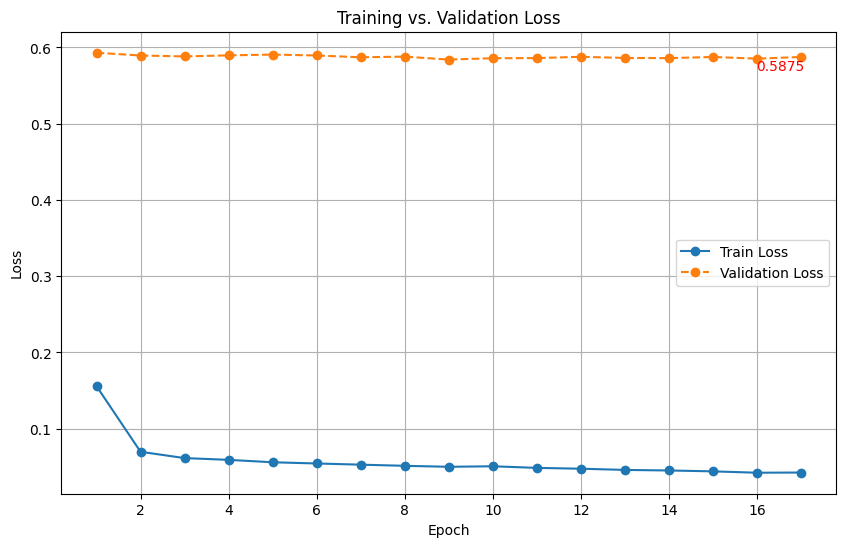

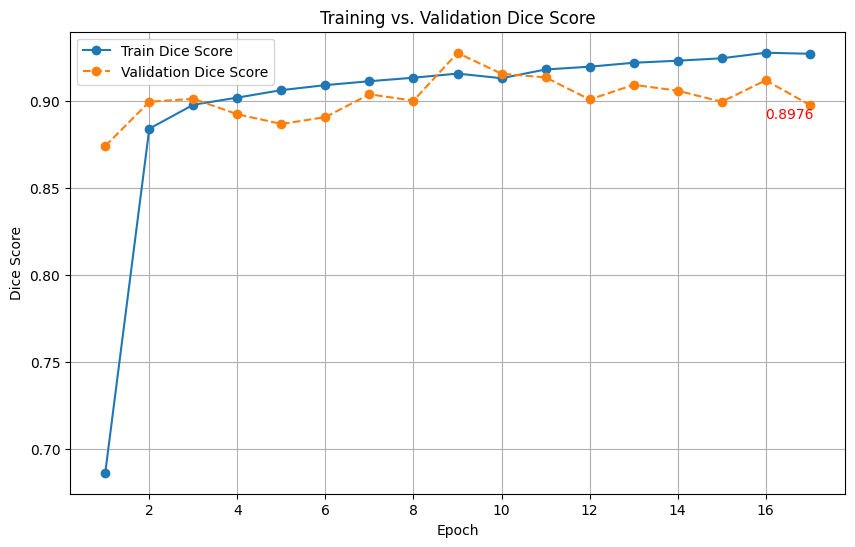

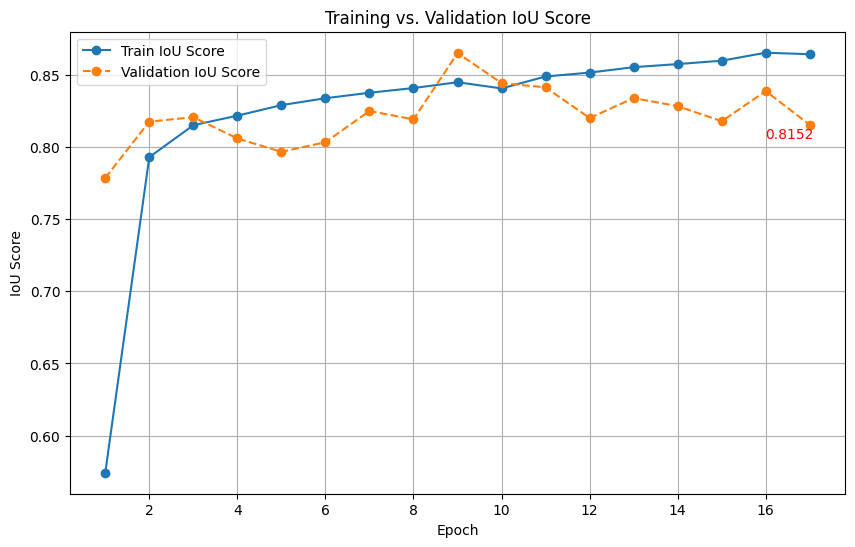

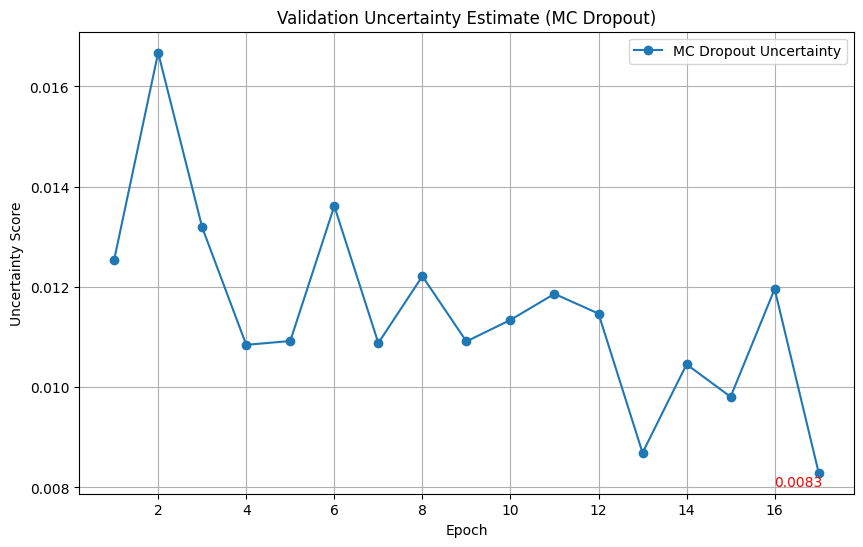

In [32]:
# Define the epoch range
epochs = range(1, len(train_losses) + 1)

# -----------------------------------------------
# Plot Training vs Validation Loss
# -----------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, marker='o', linestyle='-', label='Train Loss')
plt.plot(epochs, val_losses, marker='o', linestyle='--', label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.annotate(f"{val_losses[-1]:.4f}", (epochs[-1], val_losses[-1]), textcoords="offset points", xytext=(-15,-10), ha='center', fontsize=10, color='red')
plt.show()

# -----------------------------------------------
# Plot Training vs Validation Dice Score
# -----------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_dice_scores, marker='o', linestyle='-', label='Train Dice Score')
plt.plot(epochs, val_dice_scores, marker='o', linestyle='--', label='Validation Dice Score')
plt.title('Training vs. Validation Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()
plt.grid(True)
plt.annotate(f"{val_dice_scores[-1]:.4f}", (epochs[-1], val_dice_scores[-1]), textcoords="offset points", xytext=(-15,-10), ha='center', fontsize=10, color='red')
plt.show()

# -----------------------------------------------
# Plot Training vs Validation IoU Score
# -----------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_iou_scores, marker='o', linestyle='-', label='Train IoU Score')
plt.plot(epochs, val_iou_scores, marker='o', linestyle='--', label='Validation IoU Score')
plt.title('Training vs. Validation IoU Score')
plt.xlabel('Epoch')
plt.ylabel('IoU Score')
plt.legend()
plt.grid(True)
plt.annotate(f"{val_iou_scores[-1]:.4f}", (epochs[-1], val_iou_scores[-1]), textcoords="offset points", xytext=(-15,-10), ha='center', fontsize=10, color='red')
plt.show()

# -----------------------------------------------
# Plot MC Dropout Uncertainty Over Epochs
# -----------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(epochs, uncertainty_scores, marker='o', linestyle='-', label='MC Dropout Uncertainty')
plt.title('Validation Uncertainty Estimate (MC Dropout)')
plt.xlabel('Epoch')
plt.ylabel('Uncertainty Score')
plt.legend()
plt.grid(True)
plt.annotate(f"{uncertainty_scores[-1]:.4f}", (epochs[-1], uncertainty_scores[-1]), textcoords="offset points", xytext=(-15,-10), ha='center', fontsize=10, color='red')
plt.show()

## Step 13: Pick Random Test Images for Visualization

In [33]:
# 1. Specify the paths to your test images and masks
test_images_path = f"{BASE_DIR}/test_images.npy"
test_masks_path  = f"{BASE_DIR}/test_masks.npy"

# 2. Instantiate the test dataset
test_dataset = ISICDataset(
    images_path=test_images_path,
    masks_path=test_masks_path,
    transform=None  # Ensure same preprocessing as training
)
# Quick check
print(f"Test dataset size: {len(test_dataset)} samples")

Test dataset size: 1000 samples


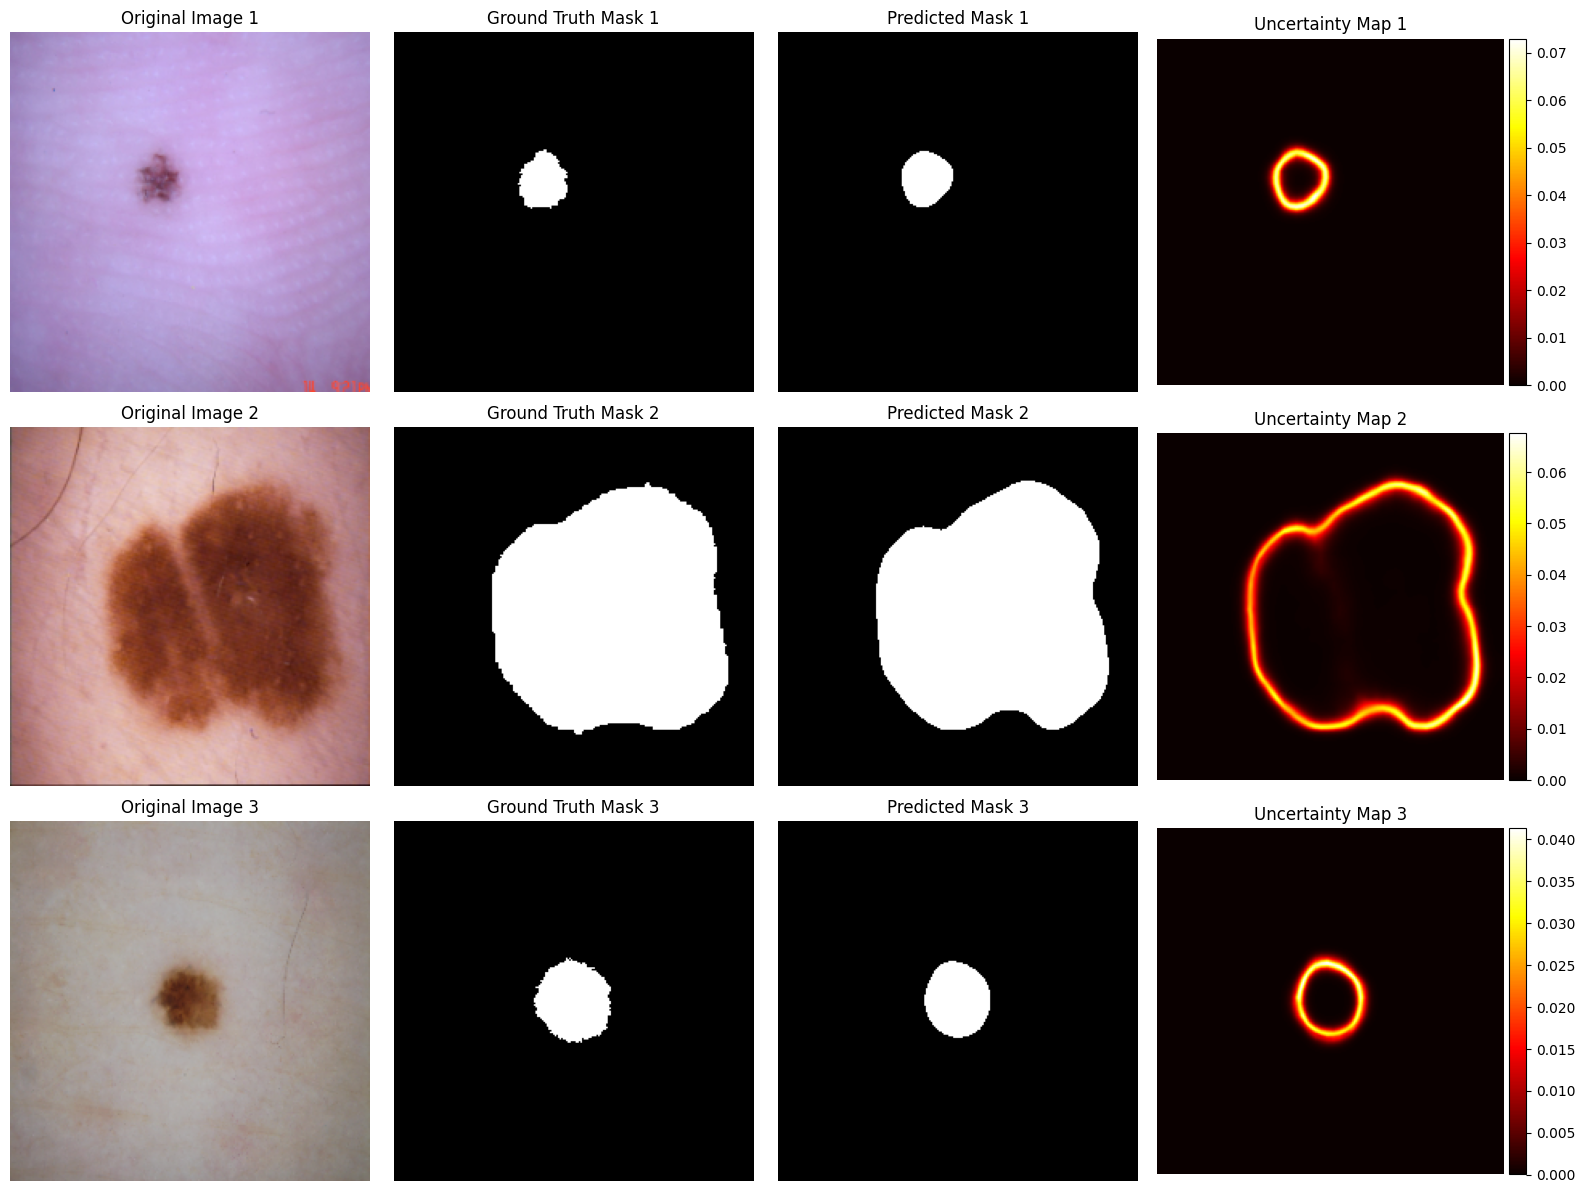

In [34]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

best_model.eval()

# Explicitly enable dropout for MC Dropout
def enable_dropout(m):
    if isinstance(m, torch.nn.Dropout) or isinstance(m, torch.nn.Dropout2d):
        m.train()

best_model.apply(enable_dropout)

# Same transformations as used in training
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

# Select random samples for visualization
random_indices = random.sample(range(len(test_dataset)), 3)
selected_images, selected_masks, selected_preds, selected_uncertainty = [], [], [], []

for idx in random_indices:
    image, mask = test_dataset[idx]

    image_np = image.permute(1, 2, 0).cpu().numpy()

    # Convert to uint8 if necessary
    if image_np.dtype != np.uint8:
        image_np = (image_np * 255).astype(np.uint8)

    image_transformed = transform(Image.fromarray(image_np))
    image_tensor = image_transformed.unsqueeze(0).to(device)

    preds_list = []
    num_mc_samples = 10
    with torch.no_grad():
        for _ in range(num_mc_samples):
            preds = best_model(image_tensor)
            preds = torch.sigmoid(preds)
            preds_list.append(preds)

    preds_array = torch.stack(preds_list, dim=0)
    preds_mean = preds_array.mean(dim=0).squeeze().cpu().numpy()
    preds_uncertainty = preds_array.std(dim=0).squeeze().cpu().numpy()

    preds_uncertainty_norm = (preds_uncertainty - preds_uncertainty.min()) / (preds_uncertainty.max() - preds_uncertainty.min() + 1e-8)
    pred_binary = (preds_mean > 0.5).astype(np.uint8)

    # Added missing line
    selected_masks.append(mask.cpu().numpy())

    selected_images.append(image_np)
    selected_preds.append(pred_binary)
    selected_uncertainty.append(preds_uncertainty.squeeze())

# Plot results
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i in range(3):
    # Original
    axes[i, 0].imshow(cv2.resize(selected_images[i], (224, 224)))
    axes[i, 0].set_title(f"Original Image {i+1}")
    axes[i, 0].axis("off")

    # Ground Truth Mask (fixed!)
    axes[i, 1].imshow(cv2.resize(selected_masks[i].astype(np.uint8), (224, 224)), cmap="gray")
    axes[i, 1].set_title(f"Ground Truth Mask {i+1}")
    axes[i, 1].axis("off")

    # Predicted Mask
    axes[i, 2].imshow(cv2.resize(selected_preds[i], (224, 224)), cmap="gray")
    axes[i, 2].set_title(f"Predicted Mask {i+1}")
    axes[i, 2].axis("off")

    # Uncertainty Map
    ax = axes[i, 3]
    im = ax.imshow(cv2.resize(selected_uncertainty[i], (224, 224)), cmap="hot")
    ax.set_title(f"Uncertainty Map {i+1}")
    ax.axis("off")

    # Add Colorbar cleanly
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax, aspect='auto')

plt.tight_layout()
plt.show()

## Step 14: Grad-CAM Visualization

Found Grad-CAM Target Layer: patch_embed.proj


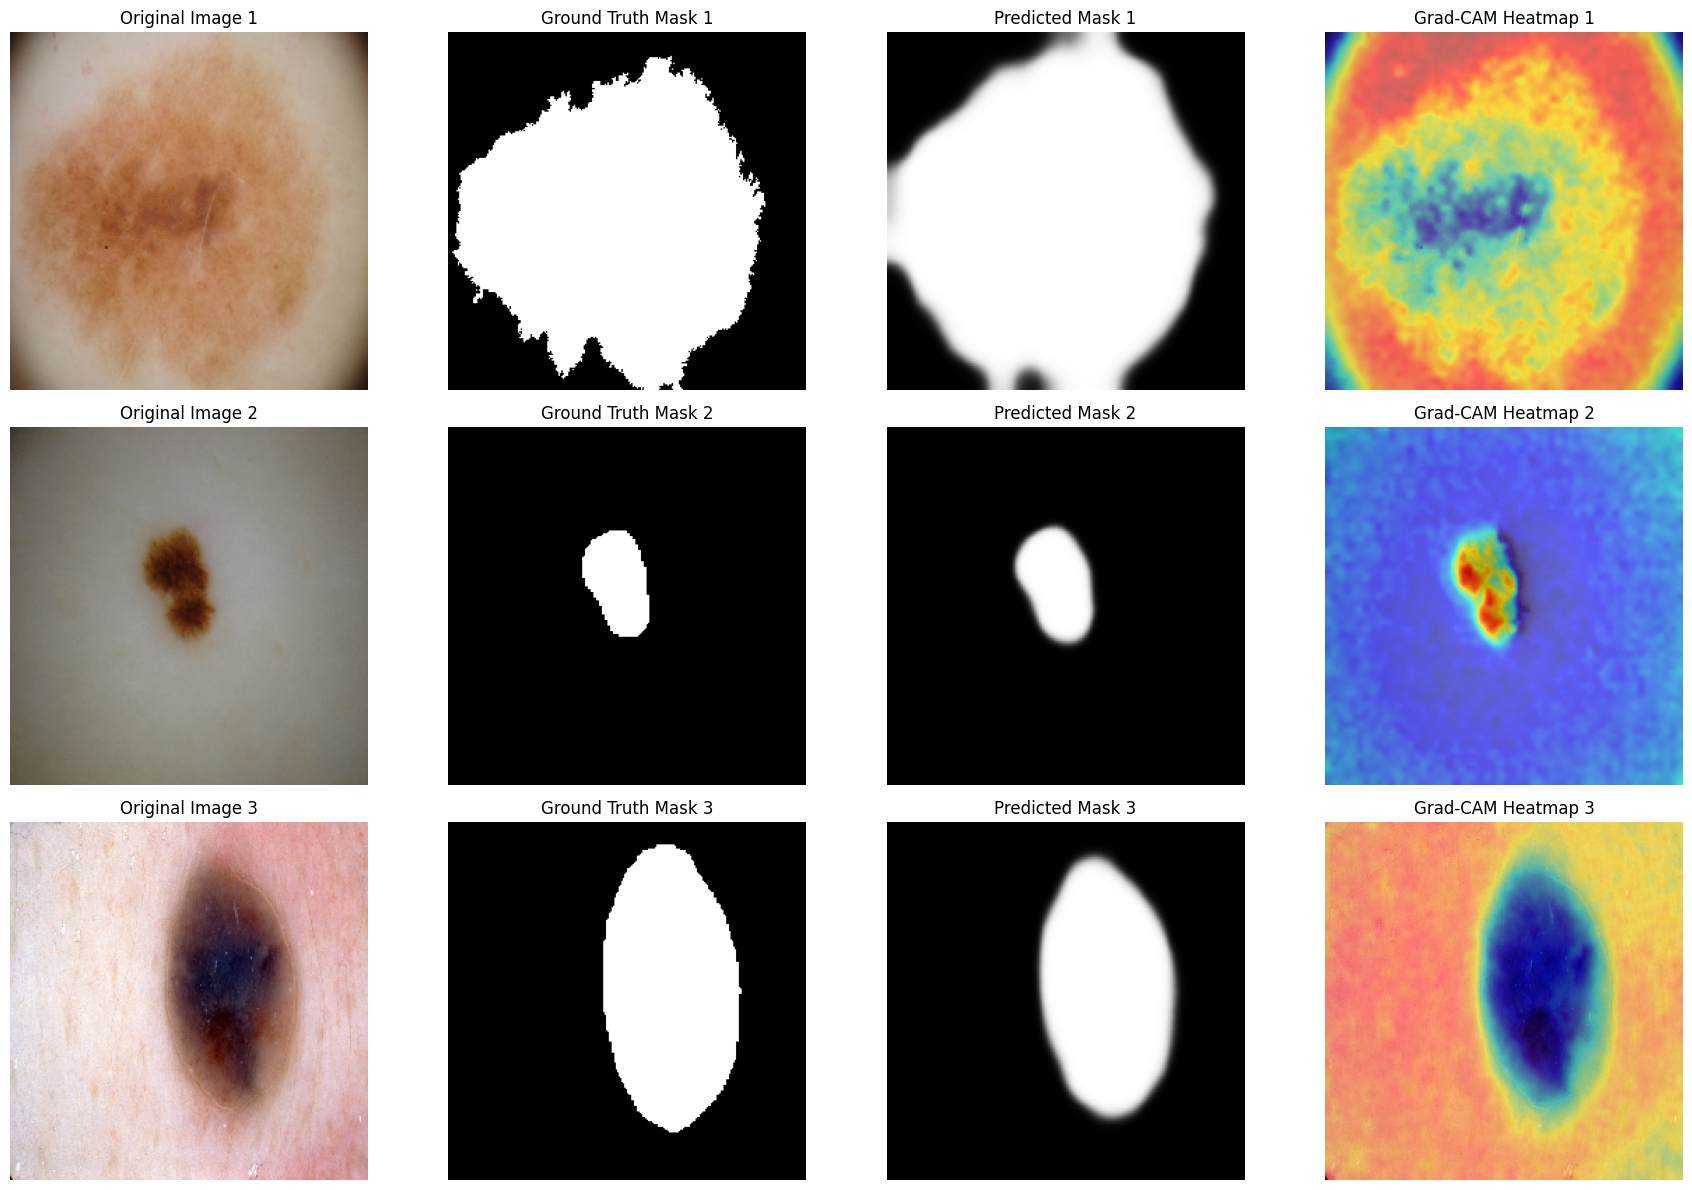

In [46]:
# -------------------------------
# Ensure model is in eval mode
# -------------------------------
best_model.eval()

# Define transformation to match Swin input size
transform = T.Compose([
    T.Resize((224, 224)),  # Resize to match Swin model input
    T.ToTensor()
])

# -------------------------------
# Find the correct Grad-CAM target layer (Last Conv Layer)
# -------------------------------
gradcam_target_layer = None
for name, module in reversed(list(best_model.encoder.named_modules())):
    if isinstance(module, torch.nn.Conv2d):  # Find the last convolutional layer
        gradcam_target_layer = module
        print(f"Found Grad-CAM Target Layer: {name}")
        break

if gradcam_target_layer is None:
    raise RuntimeError("Could not find a valid Grad-CAM target layer in the model!")

# -------------------------------
# Pick 3 random test samples
# -------------------------------
random_indices = random.sample(range(len(test_dataset)), 3)
selected_images = []
selected_masks = []
selected_preds = []
selected_gradcams = []

# Initialize Grad-CAM
cam = GradCAMPlusPlus(model=best_model, target_layers=[gradcam_target_layer])

for idx in random_indices:
    image, mask = test_dataset[idx]  # Get image & mask from test dataset

    # Convert image to numpy format safely
    image_np = image.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format

    # Convert to uint8 if necessary
    if image_np.dtype != np.uint8:
        image_np = (image_np * 255).astype(np.uint8)  # Scale to [0,255]

    # Resize the image to 224x224 BEFORE overlaying
    image_np_resized = cv2.resize(image_np, (224, 224))

    # Apply transformation (Resize + Tensor Conversion)
    image_transformed = transform(Image.fromarray(image_np))
    image_tensor = image_transformed.unsqueeze(0).to(device)  # Add batch dimension

    # Get model prediction
    with torch.no_grad():
        pred_mask = best_model(image_tensor)
        pred_mask = torch.sigmoid(pred_mask).squeeze().cpu().numpy()

    # Custom Grad-CAM Target for Semantic Segmentation
    class SegmentationTarget:
        def __init__(self, mask):
            self.mask = torch.tensor(mask).unsqueeze(0).to(device)

        def __call__(self, model_output):
            return (model_output * self.mask).sum()

    # Compute Grad-CAM heatmap
    target_mask = pred_mask > 0.5  # Binarize prediction mask
    grayscale_cam = cam(input_tensor=image_tensor, targets=[SegmentationTarget(target_mask)])[0]  # Compute Grad-CAM

    # Apply Gaussian Blur to smooth out noise
    grayscale_cam = cv2.GaussianBlur(grayscale_cam, (5, 5), 0)

    # Resize Grad-CAM to match 256x256
    grayscale_cam_resized = cv2.resize(grayscale_cam, (256, 256))

    # Overlay Grad-CAM on the original-sized image (using "jet" colormap)
    gradcam_heatmap = show_cam_on_image(image_np.astype(np.float32) / 255, grayscale_cam_resized, use_rgb=True, colormap=cv2.COLORMAP_JET)

    # Store images for plotting
    selected_images.append(image_np)  # Original image
    selected_masks.append(mask.cpu().numpy())  # Ground truth mask
    selected_preds.append(pred_mask)  # Model prediction
    selected_gradcams.append(gradcam_heatmap)  # Grad-CAM heatmap

# -------------------------------
# Plot Grad-CAM Results
# -------------------------------
fig, axes = plt.subplots(3, 4, figsize=(18, 12))

for i in range(3):
    # Original Image
    axes[i, 0].imshow(selected_images[i])
    axes[i, 0].set_title(f"Original Image {i+1}")
    axes[i, 0].axis("off")

    # Ground Truth Mask
    axes[i, 1].imshow(selected_masks[i], cmap="gray")
    axes[i, 1].set_title(f"Ground Truth Mask {i+1}")
    axes[i, 1].axis("off")

    # Predicted Mask
    axes[i, 2].imshow(selected_preds[i], cmap="gray")
    axes[i, 2].set_title(f"Predicted Mask {i+1}")
    axes[i, 2].axis("off")

    # Grad-CAM Heatmap Overlayed on Original Image
    axes[i, 3].imshow(selected_gradcams[i])  # Grad-CAM overlay
    axes[i, 3].set_title(f"Grad-CAM Heatmap {i+1}")
    axes[i, 3].axis("off")

plt.tight_layout()
plt.show()

## Step 15: Evaluating the Entire Test Set

In [47]:
# ----------------------------------------
#  Clear Cache & Reset Memory Stats
# ----------------------------------------
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

# ----------------------------------------
#  Evaluate Model on Full Test Set (With MC Dropout)
# ----------------------------------------
best_model.eval()  # Set model to evaluation mode

test_dice, test_iou, num_samples = 0.0, 0.0, 0
mc_dropout_passes = 5  # Number of stochastic forward passes for uncertainty estimation
uncertainty_scores = []  # Store uncertainty estimates

# Enable MC Dropout (Keep Dropout Active at Test Time)
def enable_dropout(model):
    """ Function to enable dropout layers during inference for MC Dropout. """
    for module in model.modules():
        if isinstance(module, torch.nn.Dropout2d) or isinstance(module, torch.nn.Dropout):
            module.train()  # Keep dropout layers active

enable_dropout(best_model)  # Activate dropout for uncertainty estimation

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.unsqueeze(1).float().to(device)  # Ensure correct shape

        # Run multiple forward passes with dropout enabled
        preds_list = []
        for _ in range(mc_dropout_passes):
            preds = best_model(images)  # Dropout remains active
            preds = torch.sigmoid(preds).detach()  # Convert logits to probabilities
            preds_list.append(preds.cpu().numpy())  # Store for uncertainty computation

        # Compute Mean & Uncertainty (Standard Deviation)
        preds_array = np.stack(preds_list, axis=0)  # Shape: [mc_dropout_passes, B, 1, H, W]
        pred_mean = preds_array.mean(axis=0)  # Mean prediction
        pred_uncertainty = preds_array.std(axis=0)  # Standard deviation as uncertainty

        # Convert to tensor for metric calculations
        pred_binary = torch.tensor(pred_mean > 0.5).int().to(device)  # Binarize predictions
        uncertainty_scores.append(pred_uncertainty.mean())  # Store mean uncertainty per batch

        # Compute Metrics
        test_dice += dice_metric(pred_binary, masks.int()).item()
        test_iou += iou_metric(pred_binary, masks.int()).item()
        num_samples += 1

# Compute Averages
test_dice /= num_samples
test_iou /= num_samples
final_uncertainty = np.mean(uncertainty_scores)  # Overall uncertainty score

# Print Final Results
print(f"Final Test Dice Score: {test_dice:.4f}")
print(f"Final Test IoU Score: {test_iou:.4f}")
print(f"Final Model Uncertainty Estimate: {final_uncertainty:.4f}")

Final Test Dice Score: 0.9015
Final Test IoU Score: 0.8228
Final Model Uncertainty Estimate: 0.0044


## Step 16: Saving the Model In Google Drive

In [48]:
# Define the model save directory
MODEL_DIR = "/content/drive/MyDrive/swinunet-medical-segmentation/models"

# Ensure the directory exists
os.makedirs(MODEL_DIR, exist_ok=True)

# Define path to save the model
MODEL_PATH = os.path.join(MODEL_DIR, "best_swin_upernet_main.pth")

# Load the best model from training before saving
best_model = SwinTinyUPerNet(num_classes=1).to(device)  # Ensure correct architecture
best_model.load_state_dict(torch.load("best_swin_upernet_main.pth", map_location=device, weights_only=True), strict=False)
best_model.eval()  # Set to evaluation mode

# Save the final best model
torch.save(best_model.state_dict(), MODEL_PATH)

print(f"Model successfully saved at: {MODEL_PATH}")

Model successfully saved at: /content/drive/MyDrive/swinunet-medical-segmentation/models/best_swin_upernet_main.pth
